In [2]:
import pandas as pd
feb_df = pd.read_csv('feb_filtered.csv')
june_df = pd.read_csv('june_filtered.csv')
august_df = pd.read_csv('aug_filtered.csv')
june_df = june_df.drop(['Unnamed: 0'], axis=1)
feb_df = feb_df.drop(['Unnamed: 0'], axis=1)
august_df = august_df.drop(['Unnamed: 0'], axis=1)
# august_df
## all species present in <20% of stations within that season have been removed

In [ ]:
## identify correlation
import seaborn as sns
df_all = pd.read_csv('allseasons.csv')
# import the scipy library
import scipy as sp
# call the seaborn scatterplot function per usual
sns.scatterplot(data=df_all, x=df_all['Bottom_Temp'], y=df_all['Bottom_Salinity'], )

# call the scipy function for pearson correlation
r, p = sp.stats.pearsonr(x=df_all['Bottom_Temp'], y=df_all['Bottom_Salinity'])
# annotate the pearson correlation coefficient text to 2 decimal places
plt.text(.05, .8, 'r={:.2f}'.format(r))

plt.show()

## Surface Temp to Bottom Temp: 0.9
## Surface Temp to Surface Salt: 0.31
## Surface Temp to Temp Strat: 0.61
## Surface Salt to Bottom Salt: 0.57
## Surface Salt to Salt Strat: 0.87
## Bottom Temp to Bottom Salt: 0.58

# can try excluding bottom temp and salt stratification from model?

In [3]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

## February Model

In [ ]:
# feb_df

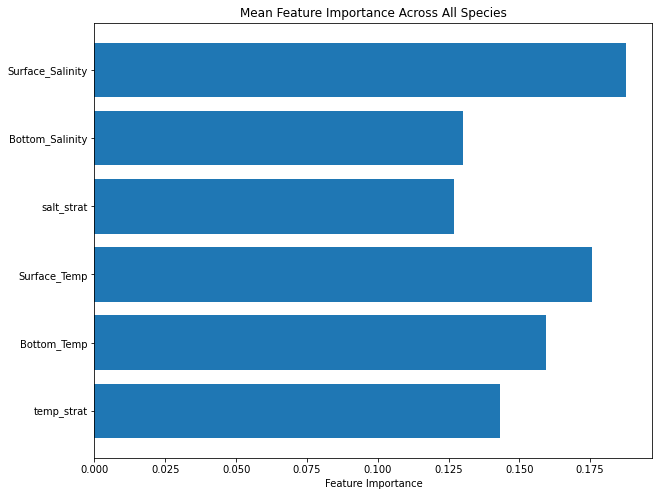

0.676923076923077


0    0.187616
1    0.130098
2    0.127084
3    0.175557
4    0.159408
5    0.143313
Name: mean_importance, dtype: float64

In [6]:
features = feb_df[['Surface_Salinity','Bottom_Salinity','salt_strat', 'Surface_Temp','Bottom_Temp','temp_strat']]
labels = feb_df.loc[:,'Atl_croaker_(nibea98)':'Atl_herring'].applymap(lambda x: 1 if x > 0 else 0)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
rf_classifier = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42
                                                             ,min_samples_split=10,min_samples_leaf=1,max_depth=10,bootstrap=True
                                                             ))
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

feb_accuracies = []
for i, species in enumerate(labels.columns):
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])    
    feb_accuracies.append(accuracy)
    # print(f"Classification report for {species}:\n", classification_report(y_test.iloc[:, i], y_pred[:, i]))

feb_average_accuracy = np.mean(feb_accuracies)

feature_importance_df = pd.DataFrame() # type: ignore
for i, species in enumerate(labels.columns):
    importances = rf_classifier.estimators_[i].feature_importances_
    feature_importance_df[species] = importances

# Calculate mean feature importance across all species
feature_importance_df['mean_importance'] = feature_importance_df.mean(axis=1)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(features.columns, feature_importance_df['mean_importance'])
plt.xlabel('Feature Importance')
plt.title('Mean Feature Importance Across All Species')
plt.gca().invert_yaxis()
plt.show()

print(feb_average_accuracy)
feature_importance_df['mean_importance']

### Hyperparameter tuning

In [ ]:
param_dist = {
    'estimator__n_estimators' : [50,100,200,500],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__bootstrap': [True, False]
}

rf_classifier = MultiOutputClassifier(RandomForestClassifier())
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

randomized_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=20, cv=3, random_state=42)
randomized_search.fit(X_train, y_train)
best_params_rand = randomized_search.best_params_
best_model_rand = randomized_search.best_estimator_
y_pred_best_rand = best_model_rand.predict(X_test)
accuracy_best_rand = accuracy_score(y_test, y_pred_best_rand)

print(f"Best RF Accuracy: {accuracy_best_rand:.2f}")
print(f"Best Hyperparameters: {best_params_rand}")


## June Model

In [ ]:
june_df

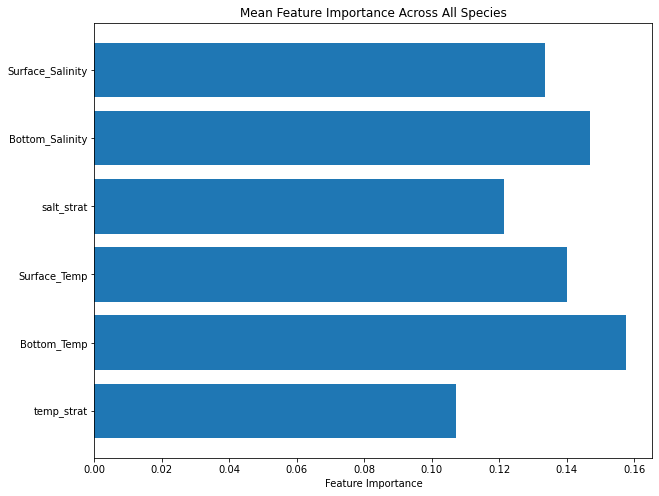

0.78494623655914


0    0.133681
1    0.146943
2    0.121266
3    0.139967
4    0.157514
5    0.107080
Name: mean_importance, dtype: float64

In [8]:
features = june_df[['Surface_Salinity','Bottom_Salinity','salt_strat', 'Surface_Temp','Bottom_Temp','temp_strat']]
labels = june_df.loc[:,'Atl_croaker_(nibea98)':'White_perch'].applymap(lambda x: 1 if x > 0 else 0)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
rf_classifier = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42
                                                             , min_samples_split=5, min_samples_leaf=1, max_depth=20, bootstrap=True))
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

accuracies = []
for i, species in enumerate(labels.columns):
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])    
    accuracies.append(accuracy)
    # print(f"Classification report for {species}:\n", classification_report(y_test.iloc[:, i], y_pred[:, i]))

june_average_accuracy = np.mean(accuracies)

feature_importance_df = pd.DataFrame() # type: ignore
for i, species in enumerate(labels.columns):
    importances = rf_classifier.estimators_[i].feature_importances_
    feature_importance_df[species] = importances

feature_importance_df['mean_importance'] = feature_importance_df.mean(axis=1)
# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(features.columns, feature_importance_df['mean_importance'])
plt.xlabel('Feature Importance')
plt.title('Mean Feature Importance Across All Species')
plt.gca().invert_yaxis()
plt.show()

print(june_average_accuracy)
feature_importance_df['mean_importance']

### June hyperparameter tuning. (run blocks together)

In [ ]:
param_dist = {
    'estimator__n_estimators' : [50,100,200,500],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__bootstrap': [True, False]
}

rf_classifier = MultiOutputClassifier(RandomForestClassifier())
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

randomized_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=20, cv=3, random_state=42)
randomized_search.fit(X_train, y_train)
best_params_rand = randomized_search.best_params_
best_model_rand = randomized_search.best_estimator_
y_pred_best_rand = best_model_rand.predict(X_test)
accuracy_best_rand = accuracy_score(y_test, y_pred_best_rand)

print(f"Best RF Accuracy: {accuracy_best_rand:.2f}")
print(f"Best Hyperparameters: {best_params_rand}")


## August Model

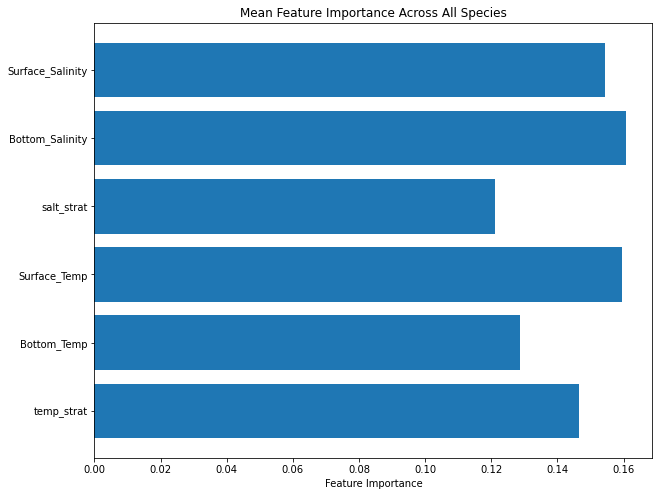

0.7903225806451613


,Atl_croaker_(nibea98),Bay_anchovy,Black_drum_or_Spot,Black_sea_bass,Brd_striped_anchovy,Nor_sea_robin,Scup,Smallmouth_flounder,Southern_kingfish(nibea95),Str_sea_robin,...,Atl_menhaden_LS16_or_river_herrings,Atl_or_nor_sand_lance,Bluefish,Silver_anchovy,Seaboard_goby,Nor_puffer,Silver_perch(nibea93),Nor_sennet95,Str_cusk_eel,mean_importance
0,0.0,0.267606,0.0,0.0,0.067842,0.0,0.093848,0.211827,0.251807,0.262495,...,0.249541,0.203916,0.222446,0.183834,0.269553,0.220620,0.210841,0.212331,0.289432,0.154427
1,0.0,0.225352,0.0,0.0,0.248641,0.0,0.297297,0.071065,0.078777,0.180563,...,0.134011,0.107480,0.121010,0.107130,0.162217,0.188231,0.144028,0.088323,0.140579,0.160676
2,0.0,0.183099,0.0,0.0,0.065124,0.0,0.118148,0.154997,0.208877,0.181204,...,0.087497,0.125654,0.119997,0.155788,0.144165,0.117127,0.188190,0.278394,0.153144,0.121131
3,0.0,0.154930,0.0,0.0,0.098489,0.0,0.060845,0.221476,0.346933,0.135414,...,0.321509,0.291433,0.258328,0.236661,0.165698,0.147053,0.205093,0.158732,0.198622,0.159432
4,0.0,0.042254,0.0,0.0,0.273046,0.0,0.192168,0.157191,0.040443,0.110305,...,0.108517,0.141287,0.131074,0.100502,0.105420,0.164813,0.128439,0.136613,0.092563,0.128801
5,0.0,0.126761,0.0,0.0,0.246858,0.0,0.237693,0.183444,0.073164,0.130020,...,0.098926,0.130229,0.147144,0.216085,0.152947,0.162156,0.123409,0.125605,0.125660,0.146501


In [10]:
features = august_df[['Surface_Salinity','Bottom_Salinity','salt_strat', 'Surface_Temp','Bottom_Temp','temp_strat']]
labels = august_df.loc[:,'Atl_croaker_(nibea98)':'Str_cusk_eel'].applymap(lambda x: 1 if x > 0 else 0)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
rf_classifier = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42
                                                             , min_samples_split=5, min_samples_leaf=2, max_depth=None, bootstrap=True))
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

accuracies = []
for i, species in enumerate(labels.columns):
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])    
    accuracies.append(accuracy)
    # print(f"Classification report for {species}:\n", classification_report(y_test.iloc[:, i], y_pred[:, i]))

aug_average_accuracy = np.mean(accuracies)

feature_importance_df = pd.DataFrame() # type: ignore
for i, species in enumerate(labels.columns):
    importances = rf_classifier.estimators_[i].feature_importances_
    feature_importance_df[species] = importances

feature_importance_df['mean_importance'] = feature_importance_df.mean(axis=1)
# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(features.columns, feature_importance_df['mean_importance'])
plt.xlabel('Feature Importance')
plt.title('Mean Feature Importance Across All Species')
plt.gca().invert_yaxis()
plt.show()

print(aug_average_accuracy)
feature_importance_df


In [ ]:
param_dist = {
    # 'estimator__n_estimators' : [50,100,200,500],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__bootstrap': [True, False]
}

rf_classifier = MultiOutputClassifier(RandomForestClassifier())
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

randomized_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=20, cv=3, random_state=42)
randomized_search.fit(X_train, y_train)
best_params_rand = randomized_search.best_params_
best_model_rand = randomized_search.best_estimator_
y_pred_best_rand = best_model_rand.predict(X_test)
accuracy_best_rand = accuracy_score(y_test, y_pred_best_rand)

print(f"Best RF Accuracy: {accuracy_best_rand:.2f}")
print(f"Best Hyperparameters: {best_params_rand}")
